### **Installing and importing all the libraries that we will use during the project**

In [1]:
%pip install --upgrade xlrd
%pip install matplotlib
%pip install geopandas
%pip install pandasql
%pip install pycountry
%pip install seaborn
%pip install plotly
%pip install statsmodels
%pip insatall folium
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import os
import os.path
import csv
import plotly.express as px 
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from ctypes import alignment
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import glob as glob
import plotly.figure_factory as ff
import pandasql as ps
import folium
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import matplotlib.colors
import pycountry
from pandas.testing import assert_frame_equal
from geopandas import GeoDataFrame


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "insatall" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.


## **Section 1: Democratic v. Not Democratic: Corruption Perceived and Income Inequality**
### Developed by **Simone Di Lorenzo**

### **Research Question** : "Is it true that in more democratic countries less corruption is perceived?"

In the first part of this section, I will do an analyzis on the CPI Score of world countries in order to see if there is any **correlation** between corruption and the country being democratic or not.

The Datasets I will use are:
- CPI Rate: https://www.kaggle.com/datasets/jeegarmaru/corruption-perceptions-index-for-10-years
- Age of electoral Democracy: https://ourworldindata.org/democracy

The first one report the CPI Score for many world countries from 2010 to 2019. **The Corruption Perceptions Index (CPI)** is an index which ranks countries "by their perceived levels of public sector corruption, as determined by expert assessments and opinion surveys. The CPI Score is based on a scale from 0 to 100 and the **higher the Score the lower corruption is perceived**in the country. This data are published annualy by the organisation **Transparency International**.  

The second datasets shows if a country is considered a **electoral democracy** from 1800 to 2019. For **electoral democracy** is intended as a political system that hold **meaningful, free and fair, and multi-party elections.**

### **Data Loding and Cleaning**
During this process I will first read my  datasets, and then  I will clean them by keeping only what I need to answer the research question.

In [2]:
#Read the CPI Score csv file from the folder where the notebook is located
df = pd.read_csv('merged_cpi_data.csv', delimiter = ",")
#create data frame and copy inside the dataset
cpi_df = pd.DataFrame(df)
#I poped the ISO3 column to then insert it back again in the datasets after removing all the column i don't need
iso_code = cpi_df.pop('ISO3')
#Removing all the column that present data that are not useful toward my goal
cpi_df_clean = cpi_df.iloc[0: , :3]
#Inset back the column of ISO3 code in the position I want and rename it to Code. 
cpi_df_clean.insert(2,'Code',iso_code)
#Rename Country that presented weired formated name or name that were not in english, which gave some problem
# Changes_country  ={'Congo':'Republic of the Congo', 'FYR Macedonia':'North Macedonia', 'The FYR of Macedonia':'North Macedonia',
#                     "Côte d'Ivoire":"Cote d'Ivoire", 'Cabo Verde':'Cape Verde', 'Macedonia':'North Macedonia'
#                     }

# cpi_df_clean.replace(to_replace=Changes_country, inplace=True)

#Finished datasets 
cpi_df_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1772 non-null   int64  
 1   Country    1772 non-null   object 
 2   Code       1740 non-null   object 
 3   CPI Score  1772 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 55.5+ KB


In [3]:
#Read the electoral democracy datasets 
df2 = pd.read_csv('age-of-electoral-democracy-bmr.csv', delimiter = ",")
#create the dataframe
dem_df = pd.DataFrame(df2)
dem_df = dem_df[~(dem_df['Year'] < 1800)]
dem_df= dem_df[~(dem_df['Year'] > 2019)]
#changing the name of the header to more meaningfull name
col = {'Entity':'Country', 'electdem_age_bmr_owid':'Status'}
dem_df.rename(columns=col, inplace=True)

#Changing name of country that are in weird format
# state_dictionary ={'Bahamas, The':'Bahamas','Bosnia & Herzegovina':'Bosnia and Herzegovina','Central African Rep.':'Central African Republic',
#                     'Democratic Republic of Congo':'Democratic Republic of the Congo','Congo':'Republic of the Congo','Czech Republic':'Czech Republic',
#                     'East Timor':'Timor-Leste','French Guiana':'Guinea','Gambia, The':'Gambia','Korea, North':'North Korea','Korea, South':'South Korea',
#                     'Macau':'Macao', 'American Samoa':'Samoa', 'Macedonia':'North Macedonia', 'United States':'United States of America', 'Czechia':'Czech Republic'
#                   }
# dem_df.replace(to_replace=state_dictionary,inplace=True)
'''
This data shows the status of democracy by 3 string value value:
- Not Democracy
- A number stating the years since the democracy was put in place
- No data: if the situation is ambiguous, data is missing or the country didn't exist.

To have a more usable dataset I decided to replace string value with integers so I could turn the whole column to integer value
and then change all the number in string back again. Resulting in having just three string value: 'Not Democratic', 'Democratic' and 'No Data'
'''
#Started by replacing with integer number the value that could not be changed by the module .to_numeric
#I've chosen 0 and -1 because then I could reconect them to their original status as democracy was rapresented only by integer > 0
replace_dem = {'non-democracy':0,'no data':-1}
dem_df.replace(to_replace=replace_dem, inplace=True)
#turned the column 'Status' in integer value
dem_df['Status']= pd.to_numeric(dem_df['Status'])
#substitute back to meaniningful value
dem_df['Status'].mask(dem_df['Status'] > 0, 'Democratic', inplace=True)
dem_df['Status'].mask(dem_df['Status'] == 0, 'Not Democratic', inplace=True)
dem_df['Status'].mask(dem_df['Status'] == -1, 'No Data', inplace=True)
# #dem_df.fillna('No Data', inplace=True)
#Here I drop(delete) all the rows that present NaN values as I noticed that there were some area without ISO3 code that were not country 
#and so not useful for my purpsose
dem_df.dropna(inplace=True)

#finsished dataset
dem_df.info(verbose=True)




<class 'pandas.core.frame.DataFrame'>
Int64Index: 45980 entries, 0 to 50386
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  45980 non-null  object
 1   Code     45980 non-null  object
 2   Year     45980 non-null  int64 
 3   Status   45980 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


While I was developing the project I noticed that some data of the more recent years were missing, so I decided to merge it ot another dataset on the same topic, from the same source, that had the missing data i needed. By combining them I ended up with a more complete dataset to work with.

In [4]:
'''
reading the datasets I will use to increase the accuracy of the main dataset by filling some missing data with more update ones.
'''
#read the csv file and create the dataframe 
df3 = pd.read_csv('age-of-electoral-democracy (1).csv', delimiter = ",")
df3.rename(columns={'electdem_age_row_owid':'Status','Entity':'Country'}, inplace=True)
#I take only the years that match the previuos and main dataset (dem_df)
df3 = df3[~(df3['Year'] < 1800)]
df3 = df3[~(df3['Year'] > 2019)]
#here I drop the countries' name column as I will merge by the ISO 3 Code and Year
df3.drop('Country',inplace=True, axis=1)

#I replicate the same process I used for the first dataset to have only three variable of democratic status
replace_dem = {'closed autocracy':0,'no data':-1,'electoral autocracy':-2}
df3.replace(to_replace=replace_dem, inplace=True)
df3['Status']= pd.to_numeric(df3['Status'])
df3['Status'].mask(df3['Status'] > 0, 'Democratic', inplace=True, errors='ignore')
df3['Status'].mask(df3['Status'] == 0, 'Not Democratic', inplace=True)
df3['Status'].mask(df3['Status'] == -1, 'No Data', inplace=True)
df3['Status'].mask(df3['Status'] == -2, 'Not Democratic', inplace=True)
#Drop the Nan Value that belong to area and not countries
df3.dropna(inplace=True)



df3.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30153 entries, 11 to 31992
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    30153 non-null  object
 1   Year    30153 non-null  int64 
 2   Status  30153 non-null  object
dtypes: int64(1), object(2)
memory usage: 942.3+ KB


In [5]:
#I merge the two datasets together I used right because I want to use the keys of the main dataframe (dem_df)
Dem_updated= pd.merge(df3,dem_df, on=['Code','Year'],how='right')
Dem_updated.reset_index(inplace=True)
Dem_updated.fillna('No Data',inplace=True)
Dem_updated.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45980 entries, 0 to 45979
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     45980 non-null  int64 
 1   Code      45980 non-null  object
 2   Year      45980 non-null  int64 
 3   Status_x  45980 non-null  object
 4   Country   45980 non-null  object
 5   Status_y  45980 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


To avoid mistake in filling the data from a datasets to another I decided to fill missing data only if the previous value on the same column was not equal to 'No Data'. I decided to do so because by looking at the datasets I realized that many countries had 'No Data' at the begining,this beacause the country didn't exist yet at the time. So by implementing this for loop I could first make sure I was filling data of a country that already existed at the time.

In [6]:
'''
for loop check, before filling the data, if previous value is not 'No Data',
and that the 'No Data' value is from the same country and not of another.
'''
for i in range(len(Dem_updated['Status_y'])):
    if Dem_updated.at[i,'Status_y']=='No Data':
        if Dem_updated.at[i-1,'Status_y']!='No Data' and Dem_updated.at[i,'Code']==Dem_updated.at[i-1,'Code']:
            Dem_updated.at[i,'Status_y']= Dem_updated.at[i,'Status_x']

Dem_updated.info(verbose=True)
#Here I drop the column Status from the dataframe I used just to fill missing value 
Dem_updated.drop(['Status_x'], axis=1,inplace=True)
#Moving column country at index 1 
first_column = Dem_updated.pop('Country')
Dem_updated.insert(1, 'Country', first_column)
#Rename Status column header to the original name
Dem_updated.rename(columns={'Status_y':'Status'},inplace=True)

#Final and cleaned datasets on democracy 
Dem_updated.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45980 entries, 0 to 45979
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     45980 non-null  int64 
 1   Code      45980 non-null  object
 2   Year      45980 non-null  int64 
 3   Status_x  45980 non-null  object
 4   Country   45980 non-null  object
 5   Status_y  45980 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45980 entries, 0 to 45979
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    45980 non-null  int64 
 1   Country  45980 non-null  object
 2   Code     45980 non-null  object
 3   Year     45980 non-null  int64 
 4   Status   45980 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


####  **First Visualization: Electoral Democracies from 1800 to 2019**

With this animated map I want to show the creation and evolution of **electoral democracies** during the past 2 centuries. I Tried to give an **interactive overview of the datasets**, which I belive to be more effective than a dataframe for visualization purposes. I decided to asign the color blue to the democratic state and red to the not democratic countries.My choice was influenced by the fact that the color blue is very commonly used to represent democracy and freedom. It can be found in the European Union and The united States flags. While I chose red because it gives a good contrast and is also very commonly used in opposition to blue.

In [7]:
#First Visualization a Map that shows the status of democracy during the years from 1800 to 2019
#Source: https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth.html
fig = px.choropleth(Dem_updated,               
              locations="Code",               
              color="Status",
              hover_name="Country",  
              animation_frame="Year", 
              title='Spread of Democracy 1800-2020', 
              color_discrete_map={'Democratic':'#2B3BFF','Not Democratic':'#ED2139','No Data':'#9E9E9E'},    
              height=500,
              category_orders={"Status": ["Not Democratic", "Democratic", "No Data"]}

              )  
#This command speed the transition up 
#Source: https://stackoverflow.com/questions/61731161/increasing-speed-on-plotly-animation
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.layout.update(showlegend=True,margin=dict(l=30, r=30, t=50, b=20))
fig.show()       

Note: Animated plots might not work on Visual Studio Code as it is not yet implemented in the Jupyter Notebook extension. By my experience on Google Collab they work flawlessly

### **Focus on the period 2010-2019**

I needed to narrow down the dataset to the time period between 2010 and 2019 so I could put it in comparison with the Corruption data I gathered from the CPI Score dataset.



In [8]:
'''
To match the time period of The CPI Score datasets I will extract from the democracy datasets the data from 2010 to 2019
'''
#Create an empty dataframe
Dem_2010_2019 = pd.DataFrame()

#From the democracy datasets I will delete all the data before than 2010 and after 2019
Dem_2010_2019 = Dem_updated[~(Dem_updated['Year'] < 2010)]
Dem_2010_2019 = Dem_2010_2019[~(Dem_2010_2019['Year'] > 2019)]

Dem_2010_2019.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 210 to 45979
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    2090 non-null   int64 
 1   Country  2090 non-null   object
 2   Code     2090 non-null   object
 3   Year     2090 non-null   int64 
 4   Status   2090 non-null   object
dtypes: int64(2), object(3)
memory usage: 98.0+ KB


In [9]:
#Here I merge the 2010-2019 democracy dataset with the CPI Score datasets to have all the data in the same dataframe
Corruption_df = pd.merge(cpi_df_clean,Dem_2010_2019, on=['Code','Year'],how='inner')
Corruption_df.drop('Country_y', axis=1, inplace=True)
#moving year column
Year_col=Corruption_df.pop('Year') 
Corruption_df.insert(2,'Year',Year_col)
#drop column that changed name during the merginfg process
Corruption_df.rename({'Country_x':'Country','Status_x':'Status'},inplace=True, axis=1)
#reset indexes so they will start from 0, as the merging process messed with the index value
Corruption_df.reset_index()

Corruption_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730 entries, 0 to 1729
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    1730 non-null   object 
 1   Code       1730 non-null   object 
 2   Year       1730 non-null   int64  
 3   CPI Score  1730 non-null   float64
 4   index      1730 non-null   int64  
 5   Status     1730 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 94.6+ KB


### **Second Visualization**: Do democratic Countries have higher CPI Score?

I decided to show the CPI Score from 2010 to 2019 in a subplot environment. I decided to use one scatterplot per year, as doing only one was very messy and not clear. I assigned to the x-axis the countries and on the y-axis the CPI Score, I colored each marker based on their democratic status, red if not democratic and blue if democratic. 

From the visulization we can see that on the top, where the CPI Score is higher, we have more blue markers, so more democratic countries, while toward the bottom we have an higher concentration of not democratic states, depicted by the red dots. We see red dots also in the mid section of the plot, but rarely on the top where we see only democratic states. This pattern stays very consistent through all the years.

To answer the question we can say that the top positions are always occupied by democratic states.In some rare cases not democratic countries achieve high score, as we can see from the few red markers around the 70-75 range, like in 2010. Some not democratic countries share the mid-section with many other democratic states. For sure not democratic state largely occupies the lower section of the scale, as most of the not democratic countries have scores under 40.

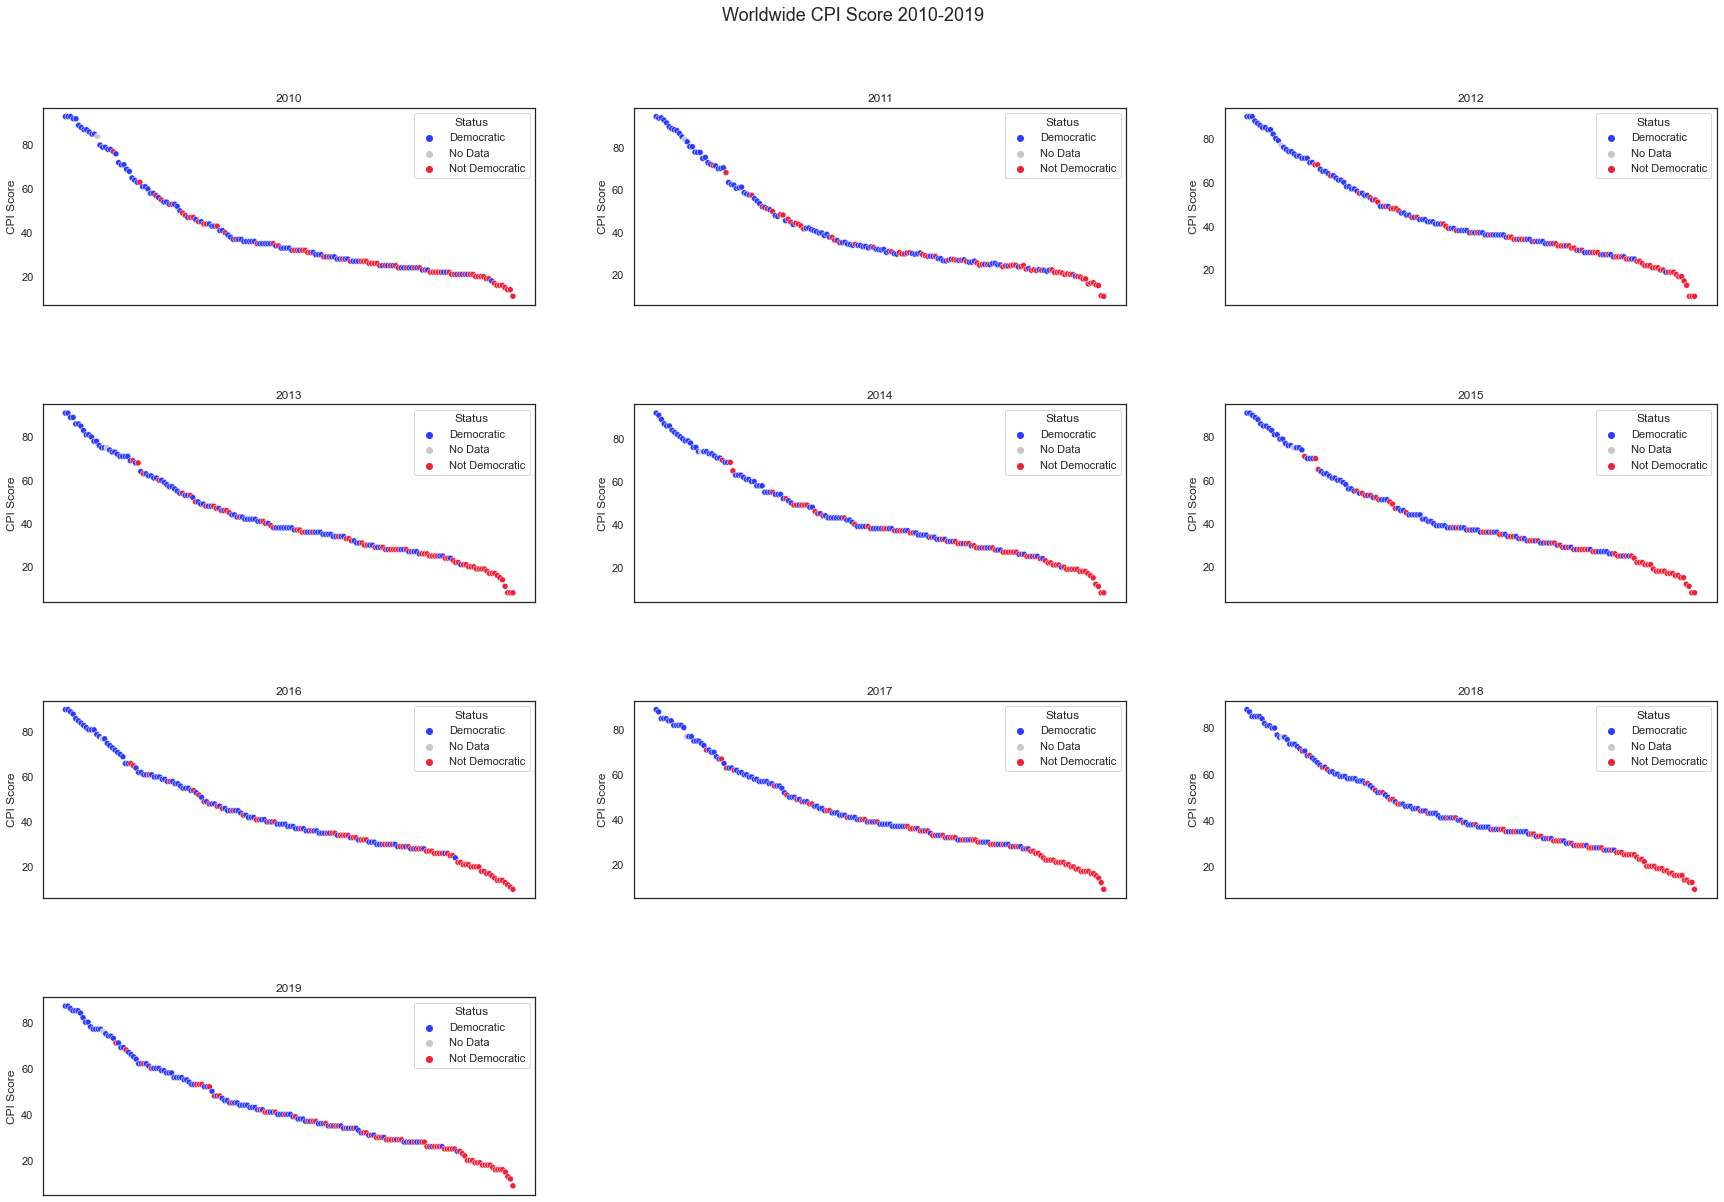

In [10]:
#Creating the subplot space to plot multiple scatterplot of different years
sns.set(rc = {'figure.figsize':(30,20)})
sns.set_theme(style='white')
#create the subplot environment with 4 rows and 3 column
fig, axes = plt.subplots(4, 3)
#increase the space from the top to leave white space for the title
plt.subplots_adjust(hspace=0.5)
#tittle of the plot
fig.suptitle("Worldwide CPI Score 2010-2019", fontsize=18, y=0.95)
# giving a title to all the plot in the subplot with the related year
for i, ax in enumerate(axes.ravel()):
    ax.set_title(f'201{i}') 
    ax.set(xticklabels=[]) 

clrs = {'Democratic':'#2B3BFF','No Data':'#C9C7C8','Not Democratic':'#ED2139'}
#creatign all the different plot for each year and removing teh lable of x axes that were too cramped and overlapping eachother
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2010], 
                palette=clrs,legend=True,ax=axes[0,0]).set(xlabel=None)
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2011], 
                palette=clrs,legend=True,ax=axes[0,1]).set(xlabel=None)
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2012], 
                palette=clrs,  legend=True,ax=axes[0,2]).set(xlabel=None)
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2013], 
                palette=clrs,  legend=True,ax=axes[1,0]).set(xlabel=None) 
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2014], 
                palette=clrs,  legend=True,ax=axes[1,1]).set(xlabel=None) 
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2015], 
                palette=clrs,legend=True,ax=axes[1,2]).set(xlabel=None) 
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2016], 
                palette=clrs,  legend=True,ax=axes[2,0]).set(xlabel=None) 
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2017], 
                palette=clrs,  legend=True,ax=axes[2,1]).set(xlabel=None)
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2018],
                palette=clrs,  legend=True,ax=axes[2,2]).set(xlabel=None) 
sns.scatterplot(x='Code', y='CPI Score', hue='Status', 
                data=Corruption_df[Corruption_df['Year']==2019], 
                palette=clrs,  legend=True,ax=axes[3,0]).set(xlabel=None)

#delete the last two plots that remained empty
fig.delaxes(axes[3][1])
fig.delaxes(axes[3][2])




In [11]:
#selecting only data regarding the year 2019
dem_df_2019 = Dem_updated[Dem_updated['Year']==2019]
Corruption_df_2019 = Corruption_df[Corruption_df['Year']==2019]

### **Third Visualization**: There is any correlation between CPI Score and democracy?
I decided to take a deeper focus on the data of 2019, plotting two maps. The first that shows the CPI Score of each country and the second that shows if a country is democratic or not.

In [12]:
#to Compare CPI Score and the democratic situation worldwide I decided to build two maps
#Firt map that shows the CPI Score of 2019
fig1 = px.choropleth(Corruption_df_2019,               
              locations="Code",               
              color="CPI Score",
              hover_name="Country", 
              title='CPI Score 2019: Darker = More Corruption',
              color_continuous_scale= 'reds_r' ,   
              height=500, )  
#Second map that shows which countries are democratic, not democratic in 2019
fig2 = px.choropleth(dem_df_2019,               
              locations="Code",               
              color="Status",
              hover_name="Country", 
              title='Democratic Countries in 2019', 
              color_discrete_map={'Democratic':'#2B3BFF','No Data':'#C9C7C8','Not Democratic':'#ED2139'},   
              height=500)  
fig1.show()
fig2.show()

#### To have a better view I decided to put them side by side

In [13]:

#changing the value of democratic and not democratic to numeric so I can plot two map side by side
d_sub  = {'Democratic':1, 'Not Democratic':0, 'No Data':None }
dem_df_2019 = dem_df_2019.replace(to_replace=d_sub)
#creating a subplot
rows = 1
cols = 2
fig_compare = make_subplots(
    rows=rows, cols=cols,
    specs = [[{'type': 'choropleth'} for c in np.arange(cols)] for r in np.arange(rows)],
    subplot_titles=['Democratic Countries in 2019','CPI Score 2019'])

#creating the first map on Corruption
fig1 = go.Choropleth(
                    locations=Corruption_df_2019.Code,
                    z = Corruption_df_2019['CPI Score'],
                    locationmode = 'ISO-3', 
                    marker_line_color=None,
                    showlegend= False, 
                    showscale=False,
                    colorscale='reds_r',
                    hoverinfo='skip'
                    )
#creating the second map showing the electoral democratic state in 2019
fig2 = go.Choropleth(
                    locations=dem_df_2019.Code,
                    z = dem_df_2019.Status,
                    locationmode = 'ISO-3', # set of locations match entries in `locations`
                    marker_line_color=None,
                    colorscale= ['red','blue'],
                    showlegend= False, 
                    showscale=False,
                    hoverinfo='skip'
                    ) 
#adding the two map to the subplot
fig_compare.add_trace(fig1, row=1, col = 2)
fig_compare.add_trace(fig2, row=1, col = 1)
#editing the graphical apearence of the visualization
#Main Title and changing the size of the plot
fig_compare.update_layout(
                        title_text = 'There is correlation between democracy and low corruption?', 
                        showlegend=False,margin=dict(l=20, r=20, t=50, b=20))

fig_compare.update_layout(title_text='There is correlation between democracy and low corruption?', title_x=0.5)
fig_compare.update_annotations(dict(font_size=8))
fig_compare.layout.annotations[0].update(x=0.23,y=0.85)
fig_compare.update_annotations(font_size=14)
fig_compare.layout.annotations[1].update(x=0.78,y=0.85)
fig_compare.update_layout(coloraxis_colorbar_x=-0.15)
fig_compare.add_annotation(dict(x=1+0.078, y=-0.06,xref="paper", yref="paper", 
                                     text='CPI Score' , showarrow=False)
                                     )
fig_compare.add_annotation(dict(x=1-0.085, y=0.12,xref="paper", yref="paper", 
                                     text='(Darker the color more corruption is perceived)' , showarrow=False)
                                     )
fig_compare.show()



From this visualization we can confirm the observation I have made on the scatter plots above. Generally not democratic states are darker on the right map, confirming that there is more perceived corruption. Anyways we cannot avoid to point out that we have an **abnormal situation** in the northern part of South America, where corruption is very high but most of the countries are in fact democratic. If we take a closer look at this part of the plot we can also notice that the darkest spot (Venezuela) is not democratic and also the most corrupt of the area.
Looking at the visualization I believe that the existance of a correlation between democracy and corruprion is possible, at least in 2019. Some exception exists, like the one I raised above. But generaly democratic countries show lower level of corruption perceived than not democratic countries

### **Forth Visualization**: CPI Score 2019: Top 10 v. Bottom 10
I decided to compare the Top 10 countries scoring the highest CPI Scores versus the bottom 10 that scored the lowest ones. I think a barchart is the best plot to show this comparison. To keep consinstency in my visualization I used colors to tell the two group apart, blue for democratic countries and red for not democratic. I also chose to put all 20 countries on the same graph for a better visualization of the gap between this positions. To make the visualization cleaner and clearer for the viewer I separatet the top 10 from the bottm 10 with a dotted line and used annotation to state which section shows which group.

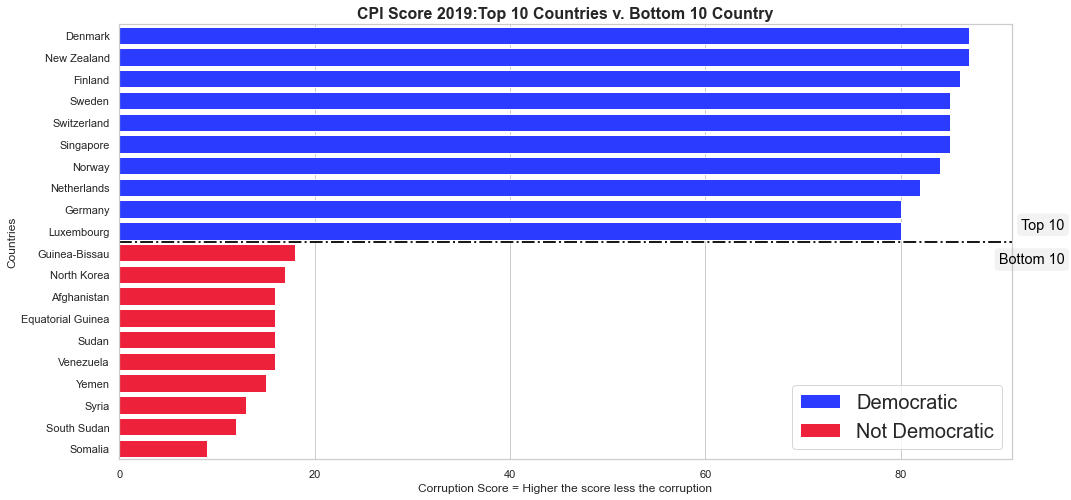

In [14]:
#Selecteded the top10 and bottom10 country on CPI Score in 2019
Corruption_2019 = pd.DataFrame(Corruption_df[Corruption_df["Year"] == 2019])
Corruption_2019.sort_values('CPI Score', inplace=True, ascending=False)
Corruption_2019_top10 = Corruption_2019.head(10)
Corruption_2019_flop10 = Corruption_2019.tail(10)
#Joining the two datasets in one to create the barchart
Corruption_2019_top_flop_10 = pd.concat([Corruption_2019_top10, Corruption_2019_flop10], ignore_index = True, axis = 0)

#setting the figure size and theme of the plot
sns.set(rc = {'figure.figsize':(16,8)})
sns.set_theme(style='whitegrid')

clrs = {'Democratic':'#2B3BFF','No Data':'#C9C7C8','Not Democratic':'#ED2139'}
#creating the barchart
b = sns.barplot(y="Country",
                x="CPI Score",hue='Status',  palette= clrs, saturation= 1 ,           
                data=Corruption_2019_top_flop_10,
                orient='h', dodge=False )
#adding lable on both axis
plt.xlabel("Corruption Score = Higher the score less the corruption")
plt.ylabel("Countries")
#adding a title
plt.title("CPI Score 2019:Top 10 Countries v. Bottom 10 Country", fontsize=16, weight='semibold')
# adding a separetor line to make the difference between top 10 countries to bottom 10 countries
plt.axhline(y=9.5,linewidth=2, color='k',linestyle ='dashdot')
#adding the legend to the plot
fontsize=20
plt.legend(loc="lower right", frameon=True, fontsize=fontsize)
#adding annotation to make clear what data are in the relative section
plt.text(95+1.75, 11-0.5, "Bottom 10", horizontalalignment='right', size='large', color='black',
            bbox=dict(facecolor='gray', alpha=0.1, boxstyle='round')) 
plt.text(95+1.75, 9-0.1, "Top 10", horizontalalignment='right', size='large', color='black',
            bbox=dict(facecolor='gray', alpha=0.1, boxstyle='round')) 
plt.show()


This visualization still confirm what we saw in the first plot. the top positions are occupied by democratic countries while not democratic countries populate the bottom one. 

## **Conslusion**

I developed four visualization to see if electoral democracies in general have higher CPI Score and so less corruption. To conclude and answer the research question. From the data that I analyzed and visualized, I can say that a correlation is highly possible, and that democratic countries genrally show less corruption perceived. But there are some exception that undermine this certainty and do not allow me to say with onehundred percent cetainty that CPI Score is dependent on the democratic situation of the country. But I can say that generaly it influence it. As we saw democratic countries occupied all the top positions in 2019 and as shawn by the first visualization the trend is clear, democratic countries generally score higher CPI score than not democratic countries.  

### **A brief final look at the income inequality distribution of the top 10 v. bottom 10 countries for CPI Score** 

I decided to also take a quick look on the Income inequality in the previous sample. The dataset I used show the the income (or wealth) share captured by the population group above a given percentile value. I decided to take a look at three group: 
* Top 1%
* Top 10%
* Bottom 50%

First I need to clean and prepare the datasets to develop the final visualization.

In [15]:
#cleaning of income distribution
#Income
income_df = pd.read_csv('WID_Data_Income.csv', delimiter=',')
income_df.drop('Variable', axis=1, inplace=True)

#create a dictionary for the percentile
percentile = {'p90p100':'Top 10%', 'p0p50':'Bottom 50%', 'p99p100':'Top 1%'}

#Income
income_df.replace(to_replace=percentile, inplace=True)
income_df.rename(columns={'Percentile':'Range','Value':'Value:Income'}, inplace=True)

income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5310 entries, 0 to 5309
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       5310 non-null   object 
 1   Range         5310 non-null   object 
 2   Year          5310 non-null   int64  
 3   Value:Income  5310 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 166.1+ KB


In [16]:
#fixing the problem with country that are called in a different way between the two datasets

Country_to_Change = {'Brunei Darussalam':'Brunei','Cabo Verde':'Cape Verde',
                     'Congo':'Republic of the Congo', 'DR Congo':'Democratic Republic of the Congo',
                     'Cote d’Ivoire':"Cote d'Ivoire",'Korea':'South Korea', 'Lao PDR':'Laos',
                     'Russian Federation':'Russia','Sao Tome and Principe':'Sao Tome & Principe',
                     'Syrian Arab Republic':'Syria', 'USA':'United States of America','Viet Nam':'Vietnam',
                     
                    }

income_df.replace(to_replace=Country_to_Change, inplace=True)

In [17]:
#Stacked barchart on Income Inequality 
#merged with the dataset I used for the previous barchart to have data of the same country easily
BarChart = pd.merge(income_df,Corruption_2019_top_flop_10, on = ['Country','Year'])
#I needed to put each range value on a separate column so I extracted their value 
Top1= pd.DataFrame(BarChart[BarChart['Range']=='Top 1%'])
Top10 = pd.DataFrame(BarChart[BarChart['Range']=='Top 10%'])
btm50 = pd.DataFrame(BarChart[BarChart['Range']=='Bottom 50%'])
Top1.rename(columns={'Value:Income':'TOP 1%'},inplace=True)
Top10.rename(columns={'Value:Income':'TOP 10%'},inplace=True)
btm50.rename(columns={'Value:Income':'BOTTOM 50%'},inplace=True)
Top1.drop(['Range'],axis=1,inplace=True)
Top10.drop(['Range'],axis=1,inplace=True)
btm50.drop(['Range'],axis=1,inplace=True)

#I merged all the data to create a datasets with the range value on separate column instead of rows
BarChart_final = pd.merge(Top1,Top10, on=['Country','Year','Code','CPI Score','Status'])
BarChart_final = pd.merge(BarChart_final,btm50, on=['Country','Year','Code','CPI Score','Status'])
#droped useless column as we know that the year is 2019 and the CPI Score was not useful for the plot
BarChart_final.drop(['Year'],axis=1,inplace=True)
BarChart_final.drop(['CPI Score'],axis=1,inplace=True)
BarChart_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     20 non-null     object 
 1   TOP 1%      20 non-null     float64
 2   Code        20 non-null     object 
 3   index_x     20 non-null     int64  
 4   Status      20 non-null     object 
 5   TOP 10%     20 non-null     float64
 6   index_y     20 non-null     int64  
 7   BOTTOM 50%  20 non-null     float64
 8   index       20 non-null     int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 1.6+ KB


In [18]:
#Here I move the column that I want to  put in the barplots to the front after country to make it easier to plot the graph
Top1_col= BarChart_final.pop('TOP 1%')
Top10_col= BarChart_final.pop('TOP 10%')
btm50_col= BarChart_final.pop('BOTTOM 50%')
BarChart_final.insert(1,'BOTTOM 50%',btm50_col)
BarChart_final.insert(2,'TOP 10%',Top10_col)
BarChart_final.insert(3,'TOP 1%',Top1_col)
BarChart_final.drop(['index_x','index_y','index'],axis=1, inplace=True)

### **Fifth Visualization**: Income Inequlity 2019

My goal with this visualition is not to answer any question, but  to  see if in democratic countries the income is more spread across the population and not concentrated in the richer population. As a side effect of corruption is for sure the concentrantation of wealth in the richer population. 

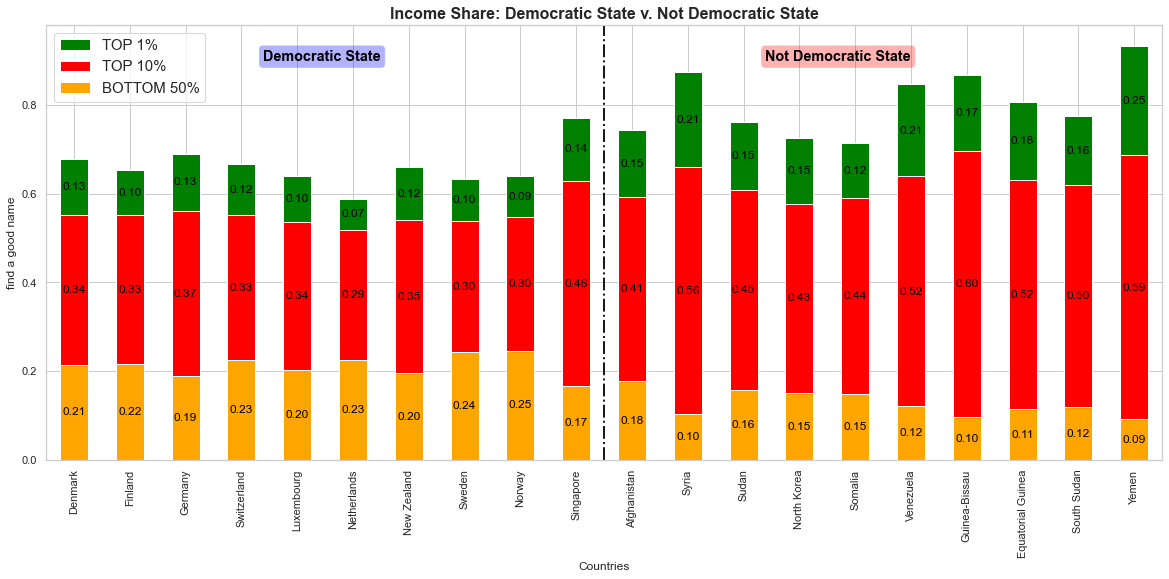

In [19]:
#I sort the value on Status to have first Democratic countries and then Not democratic countries
BarChart_final.sort_values('Status', inplace=True)

sns.set(rc = {'figure.figsize':(20,8)})
sns.set_theme(style='whitegrid')
#create the stacked barchart
ax = BarChart_final.set_index('Country').plot(kind='bar', stacked=True, color=['orange', 'red','green'], )
#Adding to each section the lable showing its value
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.2f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center', color='black')
#adding a separating line between democratic and not democratic countries
plt.axvline(x=9.5,linewidth=2, color='k',linestyle ='dashdot')
#Adding annotation to make clearer if countries in the section are democratic or not
plt.text(5.5, .9, "Democratic State", horizontalalignment='right', size='large', color='Black',weight='semibold',
            bbox=dict(facecolor='Blue', alpha=0.3, boxstyle='round')) 
plt.text(15, .9, "Not Democratic State", horizontalalignment='right', size='large', color='Black',weight='semibold',
            bbox=dict(facecolor='Red', alpha=0.3, boxstyle='round')) 

#creating legend and ordering its value as they are shown on the bar of the barplot so Bottom 50% first
# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()  
# specify order
order = [2,1,0]
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order],loc="best", frameon=True, fontsize=15)
#adding lable to axis
plt.ylabel('find a good name')
plt.xlabel("Countries")
#adding title of the plot
plt.title("Income Share: Democratic State v. Not Democratic State", fontsize=16, weight='semibold')

plt.show()

Even if I took in consideration only 20 countries, we can clearly see that in the top 10 democratic countries with less corruption, in 2019, the bottom 50% of the population holds more wealth that the richer top 1%, while in the 10 not democratic countries the top 1% in most of the cases have an higher share of total income, in respect to the bottom 50% of the population 